
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'ab-test-data:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F2479030%2F4213024%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240331%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240331T132436Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D617d3939cff07398140761ff600a37ff240c40add19c2e6dc32ac5cdc77abe63de131fc50a445677ac4b4c0c415e0b0309c74705f3b1366edb77c2c367ed65dc5966a00c38bd378c0b4983c24f36a64d50c3c77b26460c851c318476943a7a8052c6d426066f76da5c725be139e41b3fad28d4773ea117cf6b8ba373c3099ebf9cd5a2f061ca59a0ed6422984e0442831371db9e70c2df9e1e0c42330da9f314a6f1ce6cf7f4501850a1b10e7d61c4a059d8009b05ac50264960b954c4aa3430a3f623fabfab5c793e57fb28482e12a5854571f7d610bf91c00cbfde476898ad3d242aa004aeb3e708464093db062a7220078786c63f267b9fc91936a9a181c7'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import statsmodels.stats.api as sms
from scipy.stats import (ttest_1samp, shapiro, levene, ttest_ind, mannwhitneyu,
                         pearsonr, spearmanr, kendalltau, f_oneway, kruskal)
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.multicomp import MultiComparison
pd.set_option("display.width", 700)
pd.set_option("display.max_columns", None)
df = pd.read_csv("AB_Test_Results.csv")
print(df.head())

   USER_ID VARIANT_NAME  REVENUE
0      737      variant      0.0
1     2423      control      0.0
2     9411      control      0.0
3     7311      control      0.0
4     6174      variant      0.0


# Data Understanding

In [5]:
#TODO : compute the following : DataFrame Information, Columns in DataFrame, Counting Missing Values, Descriptive Statistics, Value Counts for VARIANT_NAME, Counting Unique Users in USER_ID

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   USER_ID       10000 non-null  int64  
 1   VARIANT_NAME  10000 non-null  object 
 2   REVENUE       10000 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 234.5+ KB


In [7]:
df.columns

Index(['USER_ID', 'VARIANT_NAME', 'REVENUE'], dtype='object')

In [9]:
df.nunique()

USER_ID         6324
VARIANT_NAME       2
REVENUE          101
dtype: int64

In [11]:
df.describe()

,USER_ID,REVENUE
count,10000.000000,10000.000000
mean,4981.080200,0.099447
std,2890.590115,2.318529
min,2.000000,0.000000
25%,2468.750000,0.000000
50%,4962.000000,0.000000
75%,7511.500000,0.000000
max,10000.000000,196.010000


In [13]:
df.isnull().sum()

USER_ID         0
VARIANT_NAME    0
REVENUE         0
dtype: int64

In [17]:
df['VARIANT_NAME'].value_counts()

VARIANT_NAME
variant    5016
control    4984
Name: count, dtype: int64

# Average Revenue by VARIANT_NAME

In [19]:
#TODO
df.groupby('VARIANT_NAME')['REVENUE'].mean()

VARIANT_NAME
control    0.129013
variant    0.070070
Name: REVENUE, dtype: float64

What if H0: M1 = M2 ?
What about H1: M1 != M2 ?

So we would say that H1 is correct

# Assumptions Control:
*# 1- Normality Assumptions*
*# 2- Homogeneity of Variances Assumption*

In [22]:
# TODO : test the normality of revenue data in two groups (variant and control) within your DataFrame df using the Shapiro-Wilk test, what can you conclude ?

from scipy.stats import shapiro


# Shapiro-Wilk Test for Group A
shapiro_test_a = shapiro(df[df['VARIANT_NAME'] == 'control']['REVENUE'])
print(f'Group A: W={shapiro_test_a.statistic}, p-value={shapiro_test_a.pvalue}')

# Shapiro-Wilk Test for Group B
shapiro_test_b = shapiro(df[df['VARIANT_NAME'] == 'variant']['REVENUE'])
print(f'Group B: W={shapiro_test_b.statistic}, p-value={shapiro_test_b.pvalue}')

# Interpretation
if shapiro_test_a.pvalue > 0.05:
    print("Group A data is normally distributed")
else:
    print("Group A data is not normally distributed")

if shapiro_test_b.pvalue > 0.05:
    print("Group B data is normally distributed")
else:
    print("Group B data is not normally distributed")

Group A: W=0.01833147442513483, p-value=2.4983285100057203e-95
Group B: W=0.027033073451830147, p-value=2.7310104028899288e-95
Group A data is not normally distributed
Group B data is not normally distributed


C:\Users\Olga_hp\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 5016.
  res = hypotest_fun_out(*samples, **kwds)


the p-value is less than 0.05, we reject the null hypothesis, meaning the data is not normally distributed.

In [27]:
# TODO : test for the homogeneity of variances between two groups (variant and control) within your DataFrame df using the Levene's test,  what can you conclude ?

from scipy.stats import levene



# Levene's Test for equal variances
levene_test = levene(df[df['VARIANT_NAME'] == 'control']['REVENUE'], df[df['VARIANT_NAME'] == 'variant']['REVENUE'])
print(f'Levene’s Test: W={levene_test.statistic}, p-value={levene_test.pvalue}')

# Interpretation
if levene_test.pvalue > 0.05:
    print("Variances are equal")
else:
    print("Variances are not equal")


Levene’s Test: W=1.6158565214488871, p-value=0.2037000785338918
Variances are equal


 the p-value is greater than 0.05, we do not reject the null hypothesis, meaning the variances are equal.

# Non-Parametric Test (mannwhitneyu Test)

In [30]:
# TODO : perform the Mann-Whitney U test for comparing the average revenue between the variant and control groups in your DataFrame, what can you conclude ?

from scipy.stats import mannwhitneyu


# Mann-Whitney U Test
mannwhitney_test = mannwhitneyu(df[df['VARIANT_NAME'] == 'control']['REVENUE'], df[df['VARIANT_NAME'] == 'variant']['REVENUE'])
print(f'Mann-Whitney U Test: U={mannwhitney_test.statistic}, p-value={mannwhitney_test.pvalue}')

# Interpretation
if mannwhitney_test.pvalue > 0.05:
    print("No significant difference between the groups")
else:
    print("Significant difference between the groups")


Mann-Whitney U Test: U=12521564.0, p-value=0.47825247965294926
No significant difference between the groups


the p-value is greater than 0.05, we do not reject the null hypothesis, meaning there is no significant difference between the groups.

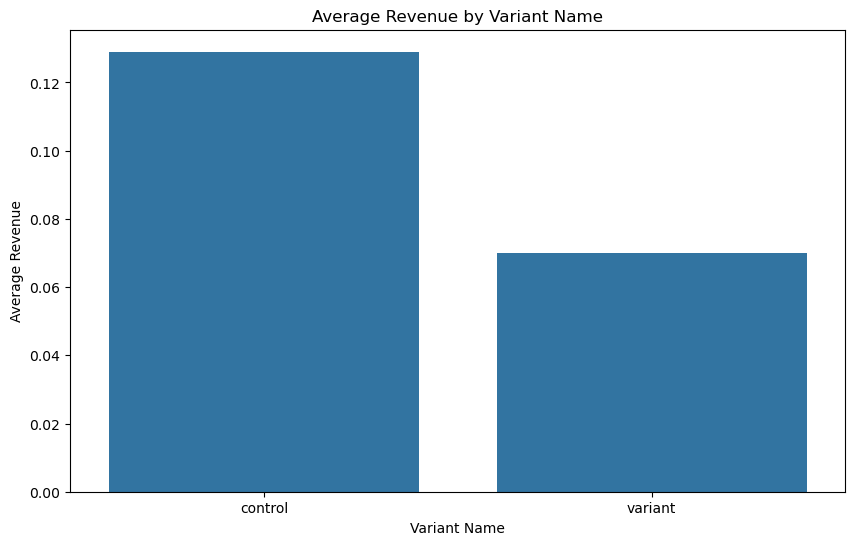

In [33]:
# TODO : create a bar plot showing the average revenues by variant names using the seaborn library

import seaborn as sns
import matplotlib.pyplot as plt

# Sample DataFrame

# Calculate average revenue by variant
average_revenue = df.groupby('VARIANT_NAME')['REVENUE'].mean().reset_index()

# Create the bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='VARIANT_NAME', y='REVENUE', data=average_revenue)
plt.title('Average Revenue by Variant Name')
plt.xlabel('Variant Name')
plt.ylabel('Average Revenue')
plt.show()
